# BaseLine Centralized model

In [ ]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from utils import get_dataset, ARGS
from update import test_inference
from models import CNNMnist

In [ ]:

args = ARGS(model='cnn', dataset='mnist', gpu=True)

device = 'cuda' if args.gpu else 'cpu'

# load datasets
train_dataset, test_dataset, _ = get_dataset(args)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


In [ ]:
# BUILD MODEL
if args.model == 'cnn':
    # Convolutional neural netork
    if args.dataset == 'mnist':
        global_model = CNNMnist(args=args)


In [ ]:
@torch.no_grad()
def calc_accuracy(model, criterion, test_loader, device):

    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    loss_avg = loss/len(testloader)

    accuracy = correct/total
    return accuracy, loss_avg

In [ ]:
from math import e
# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)


# Training
# Set optimizer and criterion
optimizer = torch.optim.Adam(global_model.parameters(), lr=args.lr,
                                    weight_decay=1e-4)

testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
criterion = torch.nn.NLLLoss().to(device)
epoch_loss = []
test_losses = []
accuracies = []


for epoch in tqdm(range(args.epochs)):
    batch_loss = []
    global_model.train()
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = global_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 250 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(images), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
        batch_loss.append(loss.item())

    acc, test_loss = calc_accuracy(global_model, criterion, testloader, device)

    loss_avg = sum(batch_loss)/len(batch_loss)
    print('\nTrain loss:', loss_avg)
    print('\nTest Loss:', test_loss)
    print('\nTest Accuracy:', acc)
    epoch_loss.append(loss_avg)
    accuracies.append(acc)
    test_losses.append(test_loss)

Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.592490

Train loss: 0.38832510296088546

Test Loss: 0.11000917805062169

Test Accuracy: 0.9669
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.419071
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.268998
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.485226
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.182100

Train loss: 0.3936161383239826

Test Loss: 0.11259960572842945

Test Accuracy: 0.9658
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.491243
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.273377
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.437638
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.387625

Train loss: 0.387505318945659

Test Loss: 0.1317438178611949

Test Accuracy: 0.959
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.486931
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.641282
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.257350
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.945694

Train loss: 0.38004411153320566

Test Loss: 0.09841281119676583

Test Accuracy: 0.97
Train Epoch: 10 [0/6

In [ ]:
calc_accuracy(global_model, criterion, trainloader, device)

(0.9680833333333333, 0.6330035014172933)

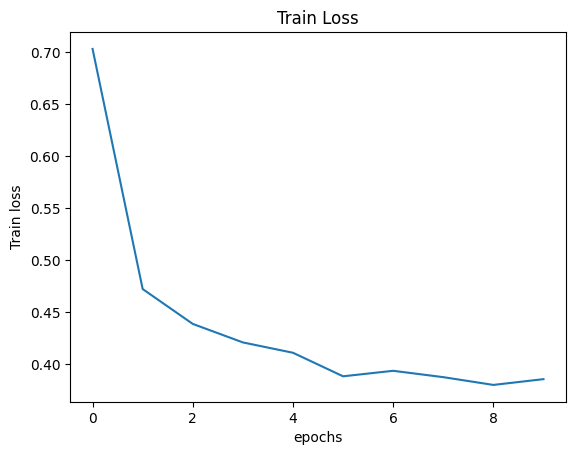

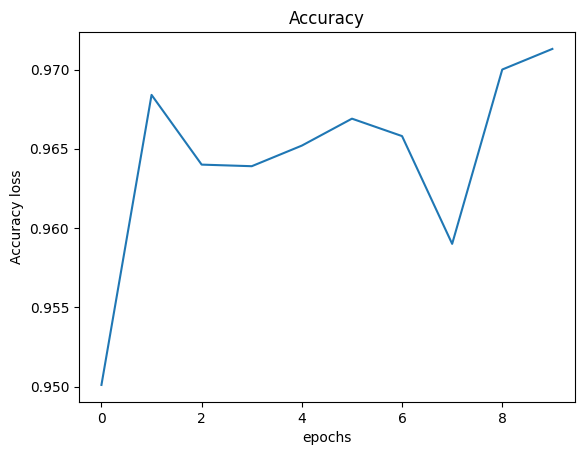

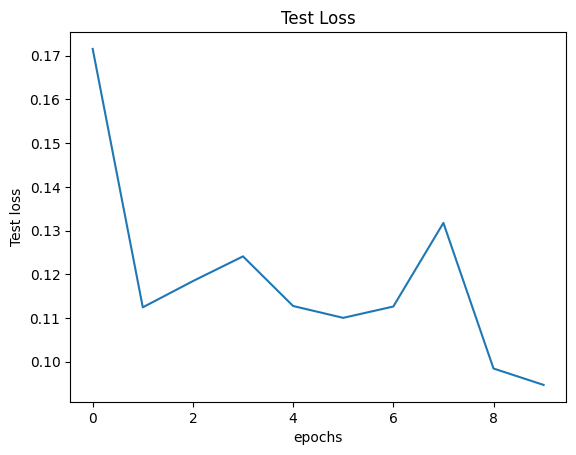

In [ ]:

# Plot loss
plt.figure()
plt.title("Train Loss")
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel('epochs')
plt.ylabel('Train loss')
plt.savefig('/content/base_train_loss_{}_{}_{}.png'.format(args.dataset, args.model, args.epochs))

plt.figure()
plt.title("Accuracy")
plt.plot(range(len(accuracies)), accuracies)
plt.xlabel('epochs')
plt.ylabel('Accuracy loss')
plt.savefig('/content/base_accuracy_{}_{}_{}.png'.format(args.dataset, args.model, args.epochs))


plt.figure()
plt.title("Test Loss")
plt.plot(range(len(test_losses)), test_losses)
plt.xlabel('epochs')
plt.ylabel('Test loss')
plt.savefig('/content/base_test_loss_{}_{}_{}.png'.format(args.dataset, args.model, args.epochs))

In [ ]:
# testing
test_acc, test_loss = test_inference(args, global_model, test_dataset)
print('Test on', len(test_dataset), 'samples')
print("Test Accuracy: {:.2f}%".format(100*test_acc))

Test on 10000 samples
Test Accuracy: 97.13%


# Federated model

In [ ]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm.auto import tqdm

import torch
from update import LocalUpdate, test_inference
from models import CNNMnist
from utils import get_dataset, average_weights, exp_details, ARGS

In [ ]:

# define paths
args = ARGS(model='cnn', dataset='mnist', gpu=True, iid=True)

exp_details(args)

device = 'cuda' if args.gpu else 'cpu'

# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)


Experimental details:
    Model     : cnn
    Optimizer : adam
    Learning  : 0.01
    Global Rounds   : 10

    Federated parameters:
    IID
    Fraction of users  : 0.1
    Local Batch size   : 10
    Local Epochs       : 10



In [ ]:
# BUILD MODEL

if args.model == 'cnn':
    # Convolutional neural netork
    if args.dataset == 'mnist':
        global_model = CNNMnist(args=args)


# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)


CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
start_time = time.time()

# copy weights
global_weights = global_model.state_dict()

# Training
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 2
val_loss_pre, counter = 0, 0

for epoch in tqdm(range(args.epochs)):
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')

    global_model.train()
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)

    for idx in idxs_users:
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                    idxs=user_groups[idx], logger=logger)
        w, loss = local_model.update_weights(
            model=copy.deepcopy(global_model), global_round=epoch)
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

    # update global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(args.num_users):
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                    idxs=user_groups[idx], logger=logger)
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))

    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))

# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

# Saving the objects train_loss and train_accuracy:
file_name = '/content/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
    format(args.dataset, args.model, args.epochs, args.frac, args.iid,
            args.local_ep, args.local_bs)

with open(file_name, 'wb') as f:
    pickle.dump([train_loss, train_accuracy], f)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |



/content/update.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)



 | Global Training Round : 2 |

 
Avg Training Stats after 2 global rounds:
Training Loss : 1.457971326786889
Train Accuracy: 15.00% 


 | Global Training Round : 3 |


 | Global Training Round : 4 |

 
Avg Training Stats after 4 global rounds:
Training Loss : 1.1364660129909074
Train Accuracy: 80.00% 


 | Global Training Round : 5 |


 | Global Training Round : 6 |

 
Avg Training Stats after 6 global rounds:
Training Loss : 0.9606062201698014
Train Accuracy: 93.33% 


 | Global Training Round : 7 |


 | Global Training Round : 8 |

 
Avg Training Stats after 8 global rounds:
Training Loss : 0.8681583650207616
Train Accuracy: 95.00% 


 | Global Training Round : 9 |


 | Global Training Round : 10 |

 
Avg Training Stats after 10 global rounds:
Training Loss : 0.8137317035482056
Train Accuracy: 88.33% 

 
 Results after 10 global rounds of training:
|---- Avg Train Accuracy: 88.33%
|---- Test Accuracy: 92.28%

 Total Run Time: 257.8083


In [ ]:
test_acc, test_loss = test_inference(args, global_model, test_dataset)
test_acc, test_loss

(0.9228, 19.60200714878738)

In [ ]:
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))


 
 Results after 10 global rounds of training:
|---- Avg Train Accuracy: 75.00%
|---- Test Accuracy: 42.79%


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

plt.figure()
plt.title('Training Loss vs Communication rounds')
plt.plot(range(len(train_loss)), train_loss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
plt.show()
plt.savefig('/content/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.format(args.dataset, args.model, args.epochs, args.frac,args.iid, args.local_ep, args.local_bs))

# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
plt.show()
plt.savefig('/content/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.format(args.dataset, args.model, args.epochs, args.frac,args.iid, args.local_ep, args.local_bs))